# Husky/Corgi Classifier

*Husky/corgi classification tool based off of Jeremy Howard's Practical Deep Learning for Coders Lesson 1*

In [1]:
!pip install -Uqq fastai

**Download Images**

In [2]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [3]:
urls = search_images('husky photos', max_images = 1)
urls[0]

'http://animalstime.com/wp-content/uploads/2019/07/Siberian-Husky-1.jpg'

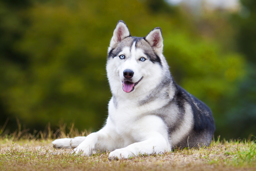

In [4]:
from fastdownload import download_url
dest = 'husky.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

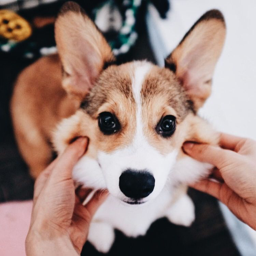

In [5]:
download_url(search_images('corgi photos', max_images=1)[0], 'corgi.jpg', show_progress=False)
Image.open('corgi.jpg').to_thumb(256,256)

**Preparing Images**

In [6]:
searches = 'husky','corgi'
path = Path('husky_or_corgi')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path, max_size=400, dest=path/o)

**Preparing Datablock**

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

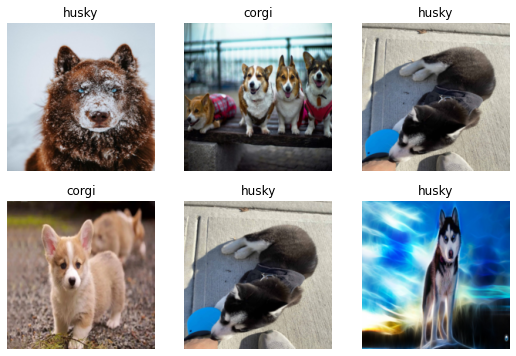

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Train Model

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/home/max/anaconda3/envs/fast/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/home/max/anaconda3/envs/fast/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.608811,0.030320,0.011583,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.042127,0.007435,0.000000,00:10
1,0.030550,0.006787,0.003861,00:10
2,0.020856,0.000623,0.000000,00:10
3,0.014836,0.000952,0.000000,00:10
4,0.010176,0.002961,0.003861,00:10


**Test using uploader.**

In [10]:
!pip install ipywidgets

from ipywidgets import *

In [11]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [12]:
img = PILImage.create(uploader.data[0])
is_dog,_,probs = learn.predict(img)
print(f"This is a: {is_dog}.")
if is_dog ==  'husky': print(f"Probability: {100 -- probs[0].item():.4f}")
else: print(f"Probability: {probs[0].item():.4f}")

This is a: husky.
Probability: 100.0000
